# Music Genera Classification With the GTZAN dataset
CS345 Fall 2024 Project   
Wade McCaulley  
Jacob Ingraham  

The topic we wish to address with this project is Music Genre Classification. Music Genre Classification has applications ranging from improved music recommendations to audio tagging for large audio libraries, which can help create more personalized music choices on platforms like Spotify. Since machine learning models specialize in extracting information from highly dimensional data, we believe that music data presents a strong opportunity. Since a song’s genre is one of the most defining aspects of a song, this classification is very well suited for machine learning. A genre is determined by many aspects such as the tempo, rhythm, instrumentation, and overall tone. 

This topic is interesting because music is an expression of emotion and a work of art. Many people prefer certain music genres because of how the songs impact their emotions. The idea of transforming songs into a collection of data points and accurately classifying them into genres is intriguing. This topic will also be challenging because audio data is very complex. Our models will have to find patterns hidden within the noise and complexity.

By comparing many different machine learning approaches we hope to learn more about this topic. The models we are comparing are K-Nearest Neighbor (KNN), Support Vector Machine (SVM), Random Forest, and Convolutional Neural Network (CNN).

In [34]:
# All necessary imports for the following code
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorboard.plugins.hparams import api as hp
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
# Place these files in the appropriate directory: Data
# Otherwise, change these filepaths
# The files can be downloaded from https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data
features_30_seconds_filepath = "../Data/features_30_sec.csv"
features_3_seconds_filepath = "../Data/features_3_sec.csv"
mel_spectrograms_filepath = "../Data/images_original"

genres = ["blues", "classical" , "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

### Datasets

The dataset consists of 10 genres, each containing 100 audio files, with each file having a duration of 30 seconds. This dataset is often referred to as "The MNIST of sounds," drawing a comparison to the well-known MNIST database of handwritten digits frequently used in CS345.

We did not manually extract features from the audio files. Instead, we utilized pre-processed data.

Music Generes:
* Blues
* Classical
* Country
* Disco
* Hiphop
* Jazz
* Metal
* Pop
* Reggae
* Rock

### Images

Images are visual representations of each audio file in the form of Mel Spectrograms. A Mel Spectrogram converts audio signals into a visual format that emphasizes frequency and amplitude over the duration of the 30-second audio file. This representation aligns with human perception of sound, as the frequency axis is transformed into the Mel scale. The Mel scale captures frequencies in a way that reflects how humans perceive pitch, allowing the audio to be digitally represented as a waveform. This visual format can then be utilized for further analysis or processing

### Reading data
The following cells read and format the data. They also split the data into train/validate/test sets to be used when choosing hyperparameters and evaluating results.

In [3]:
# Loads the CSVs. Features are everything but the first col(filename), and the lables. The lables are the last column
def loadCSVs(filepath):
    data = pd.read_csv(filepath, dtype = object, delimiter = ',').values
    X = data[:,2:-1]
    y = data[:,-1:]
    return X, y

In [4]:
# This will turn the genere lables into np.array of ints
def lable_to_int(lables, genres):
    lable_int = np.array(lables)
    for i in range(len(genres)):
        lable_int[lable_int==genres[i]]=i
    return lable_int 


In [5]:
# Loads the mel spectrograms into a np array of images. Each image is 288, 432 pixels, and each pixel is represented by four values
def load_mel_spectrograms():
    image_features = []
    image_lables = []
    for genre in genres:
        print("Loading", genre)
        images_file_path = mel_spectrograms_filepath + "/" + genre
        png_files = [f for f in os.listdir(images_file_path) if f.endswith('.png')]

        for file in png_files:
            file_path = images_file_path +"/"+ file
            image = plt.imread(file_path)  # Load the image
            image_features.append(image)
            image_lables.append(genre)

    return np.array(image_features), np.array(image_lables)

In [6]:
# Read from data file as string, then convert to a usable datatype (float)
string_X_30sec, y_30sec = loadCSVs(features_30_seconds_filepath)
X_30sec = string_X_30sec.astype(np.float64)
string_X_3sec, y_3sec = loadCSVs(features_3_seconds_filepath)
X_3sec = string_X_3sec.astype(np.float64)

# reshape y to a 1d array
y_30sec = y_30sec.ravel()
y_3sec = y_3sec.ravel()

print(X_30sec.shape, y_30sec.shape)
print(X_3sec.shape, y_3sec.shape)


(1000, 57) (1000,)
(9990, 57) (9990,)


In [7]:
# Read the spectrogram data
X_images, y_images = load_mel_spectrograms()
y_images = lable_to_int(y_images,genres)
X_images.shape, y_images.shape

Loading blues
Loading classical
Loading country
Loading disco
Loading hiphop
Loading jazz
Loading metal
Loading pop
Loading reggae
Loading rock


((999, 288, 432, 4), (999,))

In [8]:
# Split spectrogram data into train/validate/test - fulltrain will be used in the last cell to train best classifiers
#    with train and validate sets
X_images_fulltrain, X_images_test, y_images_fulltrain, y_images_test = train_test_split(X_images, y_images, test_size=0.1, shuffle=True, random_state=7)
X_images_train, X_images_val, y_images_train, y_images_val = train_test_split(X_images_fulltrain, y_images_fulltrain, test_size=0.2, shuffle=True, random_state=7)

In [9]:
# Convert label vectors to usable datatype (int)
y_30sec_int = lable_to_int(y_30sec, genres)
y_3sec_int = lable_to_int(y_3sec, genres)
y_images_int = lable_to_int(y_images, genres)
y_30sec_int.shape, y_3sec_int.shape, y_images_int.shape

((1000,), (9990,), (999,))

In [10]:
# Create normalized and standardized versions of data
X_30sec_norm = (X_30sec-np.min(X_30sec, axis=0))/(np.max(X_30sec,axis=0)-np.min(X_30sec,axis=0))
X_3sec_norm = (X_3sec-np.min(X_3sec, axis=0))/(np.max(X_3sec,axis=0)-np.min(X_3sec,axis=0))
X_30sec_std = (X_30sec-np.mean(X_30sec, axis=0))/(np.std(X_30sec, axis=0))
X_3sec_std = (X_3sec-np.mean(X_3sec, axis=0))/(np.std(X_3sec, axis=0))

In [11]:
# Check normalized and standardized data
print(np.max(X_30sec_norm)==1,np.min(X_30sec_norm)==0)
print(np.max(X_3sec_norm)==1,np.min(X_3sec_norm)==0)
print(np.mean(X_30sec_std), np.std(X_30sec_std))
print(np.mean(X_3sec_std), np.std(X_3sec_std))

True True
True True
-8.78829173176966e-18 1.0
5.5902067966304e-18 1.0


In [12]:
# Split csv data into train/validate/test - fulltrain will be used in the last cell to train best classifiers
#    with train and validate sets
X_30sec_fulltrain, X_30sec_test, y_30sec_fulltrain, y_30sec_test = train_test_split(X_30sec, y_30sec, test_size=0.1, shuffle=True, random_state=7)
X_30sec_train, X_30sec_val, y_30sec_train, y_30sec_val = train_test_split(X_30sec_fulltrain, y_30sec_fulltrain, test_size=0.2, shuffle=True, random_state=7)

X_30sec_norm_fulltrain, X_30sec_norm_test = train_test_split(X_30sec_norm, test_size=0.1, shuffle=True, random_state=7)
X_30sec_norm_train, X_30sec_norm_val = train_test_split(X_30sec_norm_fulltrain, test_size=0.2, shuffle=True, random_state=7)

X_30sec_std_fulltrain, X_30sec_std_test = train_test_split(X_30sec_std, test_size=0.1, shuffle=True, random_state=7)
X_30sec_std_train, X_30sec_std_val = train_test_split(X_30sec_std_fulltrain, test_size=0.2, shuffle=True, random_state=7)

X_3sec_fulltrain, X_3sec_test, y_3sec_fulltrain, y_3sec_test = train_test_split(X_3sec, y_3sec, test_size=0.1, shuffle=True, random_state=7)
X_3sec_train, X_3sec_val, y_3sec_train, y_3sec_val = train_test_split(X_3sec_fulltrain, y_3sec_fulltrain, test_size=0.2, shuffle=True, random_state=7)

X_3sec_norm_fulltrain, X_3sec_norm_test = train_test_split(X_3sec_norm, test_size=0.1, shuffle=True, random_state=7)
X_3sec_norm_train, X_3sec_norm_val = train_test_split(X_3sec_norm_fulltrain, test_size=0.2, shuffle=True, random_state=7)

X_3sec_std_fulltrain, X_3sec_std_test = train_test_split(X_3sec_std, test_size=0.1, shuffle=True, random_state=7)
X_3sec_std_train, X_3sec_std_val = train_test_split(X_3sec_std_fulltrain, test_size=0.2, shuffle=True, random_state=7)


## Model Selection

For Model Selection we used stratified K-Fold cross-validation with shuffling to ensure that each fold is not composed of consecutive samples. This approach helps maintain approximately the same number of samples from each genre in each fold, preventing some classes from being underrepresented.

We used accuracy_score as the metric for cross-validation. When accuracy_score is selected, it evaluates the model's performance based on its accuracy.

To automate the search for the best hyperparameters, we utilized GridSearchCV. This step was extremely slow, as we aimed to set hyperparameters for each model in a consistent manner.

The runtime for k-fold cross-validation is proportional to (O(n \times k)), where (n) is the sample size and (k) is the number of folds. We selected 5 folds, which reduces computational complexity but increases runtime. There is a risk of overfitting if one split performs significantly better than others. Fewer folds may result in less reliable estimates.

The results were outputted in a DataFrame for easy analysis. We chose the hyperparameters for the dataset with the best accuracy among all datasets.

GridSearchCV and cross-validation are computationally intensive because they systematically test multiple parameter combinations and validate performance across data subsets. During this process, the model is trained multiple times—once for each fold of cross-validation for each parameter combination.

A high-dimensional parameter grid increases the number of combinations exponentially. For example, if you have 5 hyperparameters A and 5 hyperparameters B, this requires 25 (5x5) different combinations. Adding a third hyperparameter C increases this to 125 (5x5x5) combinations.

In [13]:
# Define gridsearch function which will be used by knn, svm, random forest to choose hyperparameters
def girdSearchClassifier(model, features, labels, paramgrid):
    start_time = time.time()
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    classifier = GridSearchCV(model, paramgrid)
    classifier.fit(features, labels)
    accuracies = cross_val_score(classifier.best_estimator_, features, labels, cv=cv, 
                           scoring='accuracy')
    accuracy = np.mean(accuracies)
    run_time = time.time() - start_time


    return classifier.best_estimator_, accuracy, run_time

In [14]:
features_datasets_30sec = [
    (X_30sec, y_30sec, "Features 30 sec"),
    (X_30sec_norm, y_30sec, "Features 30 sec norm"),
    (X_30sec_std, y_30sec, "Features 30 sec std")
]

features_datasets_3sec = [
    (X_3sec, y_3sec, "Features 3 sec"),
    (X_3sec_norm, y_3sec, "Features 3 sec norm"),
    (X_3sec_std, y_3sec, "Features 3 sec std")
]

features_datasets = [
    (X_30sec, y_30sec, "Features 30 sec"),
    (X_30sec_norm, y_30sec, "Features 30 sec norm"),
    (X_30sec_std, y_30sec, "Features 30 sec std"),
    (X_3sec, y_3sec, "Features 3 sec"),
    (X_3sec_norm, y_3sec, "Features 3 sec norm"),
    (X_3sec_std, y_3sec, "Features 3 sec std")
]

## Nearest Neighbor 
The Nearest Neighbor classifier operates by identifying the example in the training dataset whose features most closely match those of the data point that needs to be classified. It then assigns the label of this closest example to the new data point

#### Nearest Neighbor Hyperparameters

The number of neighbors, denoted as n_neighbors, is the most critical hyperparameter in the Nearest Neighbor classifier. It determines how many neighbors are considered when making a prediction.

The performance of the nearest neighbor classifier can be enhanced by basing the classification on multiple neighbors. For this testing, we are using the k-Nearest Neighbors (k-NN) classifier, which compares the (k) nearest neighbors to make a decision.


#### Nearest Neighbor Running Time
The heares neighbor classifier has a running time of $O(N * d)$ where n is the number of training examples and d is the number of dimensions in the dataset

In [15]:
# Define function for choosing KNN hyperparameters on various datasets
def testKNN(features, labels, paramgrid, valFeatures, valLabels):

    model = KNeighborsClassifier()
    best_estimator, accuracy, run_time = girdSearchClassifier(model, features, labels, paramgrid)
    y_pred = best_estimator.predict(valFeatures)
    val_accuracy = np.mean(y_pred == valLabels)
    
    return best_estimator.get_params()['n_neighbors'], accuracy, val_accuracy, run_time
    

In [16]:
# Create grid and choose hyperparameters for each dataset
knn_param_grid = {
    'n_neighbors': [1,2,4,8,16,32,64,128,256,512]
}

print("knn run csv 30sec")
knn_csv30sec_best_estimator, knn_csv30sec_accuracy, knn_csv30sec_val_accuracy, knn_csv30sec_time = testKNN(X_30sec_train, y_30sec_train, knn_param_grid, X_30sec_val, y_30sec_val)

print("knn run csv 30sec norm")
knn_csv30sec_norm_best_estimator, knn_csv30sec_norm_accuracy, knn_csv30sec_norm_val_accuracy, knn_csv30sec_norm_time = testKNN(X_30sec_norm_train, y_30sec_train, knn_param_grid, X_30sec_norm_val, y_30sec_val)

print("knn run csv 30sec std")
knn_csv30sec_std_best_estimator, knn_csv30sec_std_accuracy, knn_csv30sec_std_val_accuracy, knn_csv30sec_std_time = testKNN(X_30sec_std_train, y_30sec_train, knn_param_grid, X_30sec_std_val, y_30sec_val)

print("knn run csv 3sec")
knn_csv3sec_best_estimator, knn_csv3sec_accuracy, knn_csv3sec_val_accuracy, knn_csv3sec_time = testKNN(X_3sec_train, y_3sec_train, knn_param_grid, X_3sec_val, y_3sec_val)

print("knn run csv 3sec norm")
knn_csv3sec_norm_best_estimator, knn_csv3sec_norm_accuracy, knn_csv3sec_norm_val_accuracy, knn_csv3sec_norm_time = testKNN(X_3sec_norm_train, y_3sec_train, knn_param_grid, X_3sec_norm_val, y_3sec_val)

print("knn run csv 3sec std")
knn_csv3sec_std_best_estimator, knn_csv3sec_std_accuracy, knn_csv3sec_std_val_accuracy, knn_csv3sec_std_time = testKNN(X_3sec_std_train, y_3sec_train, knn_param_grid, X_3sec_std_val, y_3sec_val) 

knn run csv 30sec
knn run csv 30sec norm
knn run csv 30sec std
knn run csv 3sec
knn run csv 3sec norm
knn run csv 3sec std


In [17]:
# Display hyperparameter choice results
knndf = pd.DataFrame({
    "Dataset": ["Features 30 sec", "Features 30 sec norm", "Features 30 sec std", "Features 3 sec", "Features 3 sec norm", "Features 3 sec std"],
    "Best n_neighbors": [
        knn_csv30sec_best_estimator,
        knn_csv30sec_norm_best_estimator,
        knn_csv30sec_std_best_estimator,
        knn_csv3sec_best_estimator,
        knn_csv3sec_norm_best_estimator,
        knn_csv3sec_std_best_estimator
    ],
    "Accuracy": [
        knn_csv30sec_accuracy,
        knn_csv30sec_norm_accuracy,
        knn_csv30sec_std_accuracy,
        knn_csv3sec_accuracy,
        knn_csv3sec_norm_accuracy,
        knn_csv3sec_std_accuracy
    ],
    "Validation Set Accuracy": [
        knn_csv30sec_val_accuracy,
        knn_csv30sec_norm_val_accuracy,
        knn_csv30sec_std_val_accuracy,
        knn_csv3sec_val_accuracy,
        knn_csv3sec_norm_val_accuracy,
        knn_csv3sec_std_val_accuracy
    ],
    "Run Time": [
        knn_csv30sec_time,
        knn_csv30sec_norm_time,
        knn_csv30sec_std_time,
        knn_csv3sec_time,
        knn_csv3sec_norm_time,
        knn_csv3sec_std_time
    ]
})
knndf

,Dataset,Best n_neighbors,Accuracy,Validation Set Accuracy,Run Time
0,Features 30 sec,32,0.308333,0.311111,2.386888
1,Features 30 sec norm,1,0.659722,0.694444,1.610049
2,Features 30 sec std,4,0.677778,0.688889,1.802073
3,Features 3 sec,32,0.298803,0.302946,6.108015
4,Features 3 sec norm,1,0.907536,0.924402,6.464905
5,Features 3 sec std,1,0.889043,0.909394,6.853821


In [18]:
# Calculate mean accuracy and mean runtime for all runs
knn_hp_avg_accuracy = knndf["Accuracy"].mean()
knn_avg_runtime = knndf["Run Time"].mean()

knn_n_hyperparameters = 10

The results indicate that using 1 neighbor in the k-Nearest Neighbors (k-NN) classifier yielded the best performance, achieving the highest accuracy. A smaller k can lead to a model that is sensitive to noise in the data and may overfit, while a larger k can smooth out the decision boundary too much, potentially missing important patterns which may result in under fitting. Since the validation set accuracy is even higher than that of the test set, it is safe to assume that the model is not overfitting. 

The performance of k-NN improved when it was run on normalized and standardized data. This may be due to the algorithm's reliance on distance calculations. Scaling ensures that all features contribute equally to these calculations, preventing any single feature from disproportionately influencing the results. This leads to more accurate identification of nearest neighbors and better overall model performance.


## SVM

The SVM or Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. It is typically used for binary classification problems, where the goal is to separate data points into two distinct classes. In SVM, the algorithm finds the optimal hyperplane that separates the data points of different classes. In a two-dimensional space, this hyperplane is a line, while in higher dimensions, it becomes a plane or a hyperplane

For this experiment we ran two different SVM models. The first was a svm with a linear kernal and tested for the optimal C paramater. We also tested the rbf kernel and looked for the optimal c and gamma parameters. 

- C Parameter: The C parameter is a regularization parameter that controls the trade-off between achieving a low training error and a low testing error. A large value of C aims to classify all training examples correctly, which might lead to overfitting. Conversely, a small value of C allows for a larger margin, potentially at the cost of some misclassifications, which may result in under fitting.
- Gamma Parameter: In the RBF kernel, the gamma parameter defines the influence of a single training example. A low gamma value means a large influence (far-reaching), resulting in a smoother decision boundary. A high gamma value means a small influence (close), leading to a more complex decision boundary that can adapt to the training data but may result in over fitting.

Linear Kernel: In a linear kernel the  decision boundary is a hyperplane in the feature space. This means it separates data points from different classes in a linear fashion. They are most effective in data that is seperated by a straight line in 2d data or a plan in higher dimensions. 

RBF Kernel: In an RBF Kernel the decision boundary allows for more complex decision boundaries. These can be curves, circles, or more intricate shape. The RBF Kernel is also known as a Gaussian kernel

In [19]:
# Define function for choosing SVM hyperparameters on various datasets
def testSVM(features, labels, paramgrid, valFeatures, valLabels):
    X_standard_scaler = StandardScaler().fit(features)
    features = X_standard_scaler.transform(features)
    model = svm.SVC()
    best_estimator, accuracy, run_time = girdSearchClassifier(model, features, labels, paramgrid)
    y_pred = best_estimator.predict(valFeatures)
    val_accuracy = np.mean(y_pred == valLabels)
    
    return best_estimator.get_params()['C'], best_estimator.get_params()['gamma'], accuracy, val_accuracy, run_time

### Features 3 seconds to large a dataset. Quadratic run time for larger data sets. 




The computational complexity of SVM is between $On^2$ and $O(n^3)$ for training. This became computational expensive for this experiment. When combined with the kfold cross vaildation and gridsearch cv this became extreemly slow for the 10,000 example dataset with 3 seconds songs. Becuase of this we only examined the 1000 example 30 second data set. Below is an example of the exponential increase in training time based on the number of examples. 

testing SVM run time on large datasets


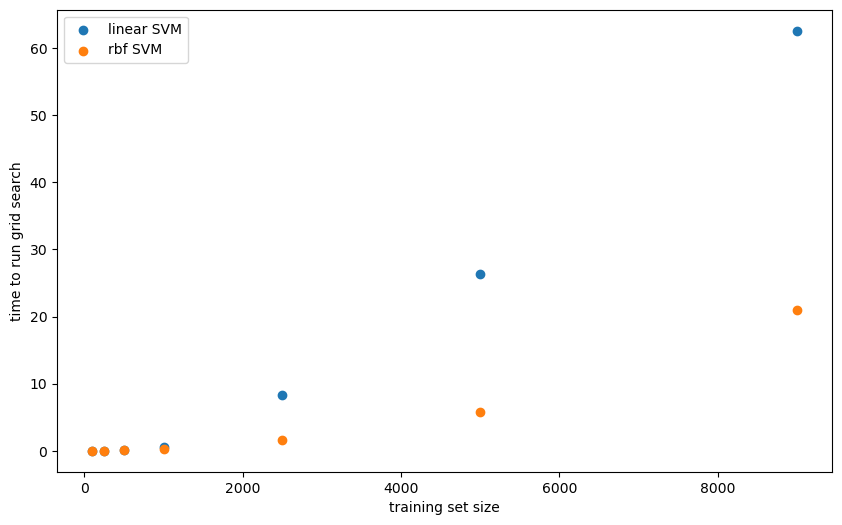

In [20]:
# Evaluate training time for SVM using data subsets of varying size
sizes = [100, 250, 500, 1000, 2500, 5000, 9000]

linear_runtimes = []
rbf_runtimes = []

print("testing SVM run time on large datasets")
X_train, X_test, y_train, y_test = train_test_split(X_3sec, y_3sec, test_size = 0.01, random_state = 1)

X_standard_scaler = StandardScaler().fit(X_train)
X_train = X_standard_scaler.transform(X_train)
for s in sizes:
    start_time = time.time()
    classifier = svm.SVC(C = 10, kernel='linear')
    classifier.fit(X_train[:s], y_train[:s])
    run_time = time.time() - start_time
    linear_runtimes.append(run_time)

for s in sizes:
    start_time = time.time()
    classifier = svm.SVC(C = 10, gamma = .1, kernel='rbf')
    classifier.fit(X_train[:s], y_train[:s])
    run_time = time.time() - start_time
    rbf_runtimes.append(run_time)
    
np_linear_runtimes = np.array(linear_runtimes)
np_rbf_runtimes = np.array(rbf_runtimes)

plt.figure(figsize=(10, 6))
plt.scatter(sizes, np_linear_runtimes, label = 'linear SVM')
plt.scatter(sizes, np_rbf_runtimes, label = 'rbf SVM')
plt.xlabel('training set size')
plt.ylabel('time to run grid search')
plt.legend()
plt.show()

Gammas Tested: Small gamma means each datapoint has a small influence, and a large gamma means each datapoint has a large influence. if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma. If auto is used it uses if ‘auto’, uses 1 / n_features for the value of gamma.   

C: Used high C values to attempt to classify each training example which may lead to overfitting. We also tested low c values which allows for some miscalssifications but reduces the risk of overfitting. 

In [21]:
''' 
    THIS CELL HAS A LONG RUNTIME - several minutes
    Choosing hyperparameter for a 3 sec dataset takes upward of 5 minutes, and there are 6 such calls in this cell
    The output of this cell usually shows the best accuracy with an rbf kernel using C=100 and gamma='scale'
'''
# Create grid and choose hyperparameters for each dataset
gammas = [.001, .01, 1, 10, 100, 'auto', 'scale']
Cs = [ .01, .1, 1, 10, 100]

rbf_svm_param_grid = [
  {'C': Cs, 
   'gamma': gammas, 
   'kernel': ['rbf']},
 ]
linear_svm_param_grid = [
  {'C': Cs, 
   'kernel': ['linear']},
 ]

print("run csv 30sec")
rbf_svm_csv30sec_best_estimator_c, rbf_svm_csv30sec_best_estimator_gamma, rbf_svm_csv30sec_accuracy, rbf_svm_csv30sec_val_accuracy, rbf_svm_csv30sec_time = testSVM(
    X_30sec_train, y_30sec_train, rbf_svm_param_grid, X_30sec_val, y_30sec_val)

print("run csv 30sec norm")
rbf_svm_csv30sec_norm_best_estimator_c, rbf_svm_csv30sec_norm_best_estimator_gamma, rbf_svm_csv30sec_norm_accuracy, rbf_svm_csv30sec_norm_val_accuracy, rbf_svm_csv30sec_norm_time = testSVM(
    X_30sec_norm_train, y_30sec_train, rbf_svm_param_grid, X_30sec_norm_train, y_30sec_train)

print("run csv 30sec std")
rbf_svm_csv30sec_std_best_estimator_c, rbf_svm_csv30sec_std_best_estimator_gamma, rbf_svm_csv30sec_std_accuracy, rbf_svm_csv30sec_std_val_accuracy, rbf_svm_csv30sec_std_time = testSVM(
    X_30sec_std_train, y_30sec_train, rbf_svm_param_grid, X_30sec_std_val, y_30sec_val)

print("run csv 3sec")
rbf_svm_csv3sec_best_estimator_c, rbf_svm_csv3sec_best_estimator_gamma, rbf_svm_csv3sec_accuracy, rbf_svm_csv3sec_val_accuracy, rbf_svm_csv3sec_time = testSVM(
    X_3sec_train, y_3sec_train, rbf_svm_param_grid, X_3sec_val, y_3sec_val)

print("run csv 3sec norm")
rbf_svm_csv3sec_norm_best_estimator_c, rbf_svm_csv3sec_norm_best_estimator_gamma, rbf_svm_csv3sec_norm_accuracy, rbf_svm_csv3sec_norm_val_accuracy, rbf_svm_csv3sec_norm_time = testSVM(
    X_3sec_norm_train, y_3sec_train, rbf_svm_param_grid, X_3sec_norm_val, y_3sec_val)

print("run csv 3sec std")
rbf_svm_csv3sec_std_best_estimator_c, rbf_svm_csv3sec_std_best_estimator_gamma, rbf_svm_csv3sec_std_accuracy, rbf_svm_csv3sec_std_val_accuracy, rbf_svm_csv3sec_std_time = testSVM(
    X_3sec_std_train, y_3sec_train, rbf_svm_param_grid, X_3sec_std_val, y_3sec_val)

print("run csv 30sec linear")
svm_csv30sec_best_estimator_c, svm_csv30sec_best_estimator_gamma, svm_csv30sec_accuracy, svm_csv30sec_val_accuracy, svm_csv30sec_time = testSVM(
    X_30sec_train, y_30sec_train, linear_svm_param_grid, X_30sec_val, y_30sec_val)

print("run csv 30sec norm linear")
svm_csv30sec_norm_best_estimator_c, svm_csv30sec_norm_best_estimator_gamma, svm_csv30sec_norm_accuracy, svm_csv30sec_norm_val_accuracy, svm_csv30sec_norm_time = testSVM(
    X_30sec_norm_train, y_30sec_train, linear_svm_param_grid, X_30sec_norm_val, y_30sec_val)

print("run csv 30sec std linear")
svm_csv30sec_std_best_estimator_c, svm_csv30sec_std_best_estimator_gamma, svm_csv30sec_std_accuracy, svm_csv30sec_std_val_accuracy, svm_csv30sec_std_time = testSVM(
    X_30sec_std_train, y_30sec_train, linear_svm_param_grid, X_30sec_std_val, y_30sec_val)

print("run csv 3sec linear")
svm_csv3sec_best_estimator_c, svm_csv3sec_best_estimator_gamma, svm_csv3sec_accuracy, svm_csv3sec_val_accuracy, svm_csv3sec_time = testSVM(
    X_3sec_train, y_3sec_train, linear_svm_param_grid, X_3sec_val, y_3sec_val)

print("run csv 3sec norm linear")
svm_csv3sec_norm_best_estimator_c, svm_csv3sec_norm_best_estimator_gamma, svm_csv3sec_norm_accuracy, svm_csv3sec_norm_val_accuracy, svm_csv3sec_norm_time = testSVM(
    X_3sec_norm_train, y_3sec_train, linear_svm_param_grid, X_3sec_norm_val, y_3sec_val)

print("run csv 3sec std linear")
svm_csv3sec_std_best_estimator_c, svm_csv3sec_std_best_estimator_gamma, svm_csv3sec_std_accuracy, svm_csv3sec_std_val_accuracy, svm_csv3sec_std_time = testSVM(
    X_3sec_std_train, y_3sec_train, linear_svm_param_grid, X_3sec_std_val, y_3sec_val)

run csv 30sec
run csv 30sec norm
run csv 30sec std
run csv 3sec
run csv 3sec norm
run csv 3sec std
run csv 30sec linear
run csv 30sec norm linear
run csv 30sec std linear
run csv 3sec linear
run csv 3sec norm linear
run csv 3sec std linear


In [25]:
# Display hyperparameter choice results
svmdf = pd.DataFrame({
    "Dataset": ["Features 30 sec", "Features 30 sec norm", "Features 30 sec std", "Features 3 sec", "Features 3 sec norm", "Features 3 sec std", "Features 30 sec", "Features 30 sec norm", "Features 30 sec std", "Features 3 sec", "Features 3 sec norm", "Features 3 sec std",],
    "Kernel": ["rbf", "rbf", "rbf", "rbf", "rbf", "rbf", "linear", "linear", "linear", "linear", "linear", "linear"],
    "Best C": [
        rbf_svm_csv30sec_best_estimator_c,
        rbf_svm_csv30sec_norm_best_estimator_c,
        rbf_svm_csv30sec_std_best_estimator_c,
        rbf_svm_csv3sec_best_estimator_c,
        rbf_svm_csv3sec_norm_best_estimator_c,
        rbf_svm_csv3sec_std_best_estimator_c,
        svm_csv30sec_best_estimator_c,
        svm_csv30sec_norm_best_estimator_c,
        svm_csv30sec_std_best_estimator_c,
        svm_csv3sec_best_estimator_c,
        svm_csv3sec_norm_best_estimator_c,
        svm_csv3sec_std_best_estimator_c
    ],
    "Best gamma": [
        rbf_svm_csv30sec_best_estimator_gamma,
        rbf_svm_csv30sec_norm_best_estimator_gamma,
        rbf_svm_csv30sec_std_best_estimator_gamma,
        rbf_svm_csv3sec_best_estimator_gamma,
        rbf_svm_csv3sec_norm_best_estimator_gamma,
        rbf_svm_csv3sec_std_best_estimator_gamma,
        'na',
        'na',
        'na',
        'na',
        'na',
        'na'
    ],
    "Accuracy": [
        rbf_svm_csv30sec_accuracy,
        rbf_svm_csv30sec_norm_accuracy,
        rbf_svm_csv30sec_std_accuracy,
        rbf_svm_csv3sec_accuracy,
        rbf_svm_csv3sec_norm_accuracy,
        rbf_svm_csv3sec_std_accuracy,
        svm_csv30sec_accuracy,
        svm_csv30sec_norm_accuracy,
        svm_csv30sec_std_accuracy,
        svm_csv3sec_accuracy,
        svm_csv3sec_norm_accuracy,
        svm_csv3sec_std_accuracy
    ],
    "Run Time": [
        rbf_svm_csv30sec_time,
        rbf_svm_csv30sec_norm_time,
        rbf_svm_csv30sec_std_time,
        rbf_svm_csv3sec_time,
        rbf_svm_csv3sec_norm_time,
        rbf_svm_csv3sec_std_time,
        svm_csv30sec_time,
        svm_csv30sec_norm_time,
        svm_csv30sec_std_time,
        svm_csv3sec_time,
        svm_csv3sec_norm_time,
        svm_csv3sec_std_time
    ]
})
svmdf

,Dataset,Kernel,Best C,Best gamma,Accuracy,Run Time
0,Features 30 sec,rbf,10.0,0.01,0.723611,21.752145
1,Features 30 sec norm,rbf,10.0,0.01,0.723611,22.418059
2,Features 30 sec std,rbf,10.0,0.01,0.723611,22.326857
3,Features 3 sec,rbf,100.0,auto,0.896691,1745.921908
4,Features 3 sec norm,rbf,100.0,auto,0.896691,1713.981888
5,Features 3 sec std,rbf,100.0,auto,0.896691,1702.373217
6,Features 30 sec,linear,0.1,na,0.705556,1.924493
7,Features 30 sec norm,linear,0.1,na,0.705556,1.951979
8,Features 30 sec std,linear,0.1,na,0.705556,1.940477
9,Features 3 sec,linear,100.0,na,0.744577,3783.548891


In [26]:
# Calculate mean accuracy and mean runtime for all runs
svm_hp_avg_accuracy = svmdf["Accuracy"].mean()
svm_hp_avg_run_time = svmdf["Run Time"].mean()

svm_n_hyperparameters_c = 5
svm_n_hyperparameters_gamma = 7

The choice of (C = 10) and (\gamma = 0.01) for your SVM model with the RBF kernel provided the best results by effectively balancing the complexity of the decision boundary with the need to generalize well to new data. It is impoortant to note that for this dataset we only used the 30second features and not 3 second due to the exmponential increases when using the 3 second set. 

The accuracy was the same acros all datasets when using the same kerenl. This was due to the use of the SandardScaler which alwayse standardizes features by removing the mean and scaling to unit variance. It transforms the data so that it has a mean of 0 and a standard deviation of 1. This is particularly useful when the features have different units or variances

## Random Forest 

A Random Forest Classifier is a supervised machine learning algorithm that is used for both classification and regression tasks. For this experiment we used it as a classifier.  It operates by constructing a multitude of decision trees during training and outputting the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random Forest is known for its high accuracy and robustness, especially in classification tasks. It reduces the risk of overfitting by averaging the results of multiple trees, which lowers the variance and prediction error.

While Random Forest is generally efficient, it can be computationally intensive with a large number of trees, which may slow down predictions. The algorithm can require significant memory, especially with large datasets and many trees

In [27]:
# Define function for choosing SVM hyperparameters on various datasets
def testRandomForest(features, labels, paramgrid, valFeatures, valLabels):
    
    model = RandomForestClassifier()
    best_estimator, accuracy, run_time = girdSearchClassifier(model, features, labels, paramgrid)
    y_pred = best_estimator.predict(valFeatures)
    val_accuracy = np.mean(y_pred == valLabels)
    
    return best_estimator.get_params()['n_estimators'], best_estimator.get_params()['max_depth'], best_estimator.get_params()['bootstrap'], accuracy, val_accuracy, run_time

#### Random Forest Parameters 

n-estimators: specifies the number of decision trees in the random forest. increasing the number of trees improves the model's performance because it reduces variance and helps the model generalize better. However, after a certain point, adding more trees yields diminishing returns in terms of accuracy and increases computational cost

max_depth: determines the maximum depth of each tree in the forest A deeper tree can capture more information about the data, but it can also lead to overfitting if the depth is too high. Conversely, a shallow tree might underfit the data. A max depth of n allows all the trees to grow until all leaves are pur or until they contain fewer than min_samples_split. We used default min sample split of 2. This was primirly to keep the complexity of the hyper parameter selection to a reasonalble speed for this experiment.

bootstrap: Determines weahter whether bootstrap samples are used when building trees. When bootstrapping the next classifier tree will attempt to focus on training examples that were miss classified. It can ensures diversity among trees by using random subsets of data, which helps in reducing overfitting.

In [28]:
# Create grid and choose hyperparameters for each dataset
random_forest_param_grid = {
    'n_estimators': [1, 10, 50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'bootstrap': [True, False],
    'n_jobs': [-1]
    
}

print("rf run csv 30sec")
rf_csv30sec_best_estimator_nfeatures, rf_csv30sec_best_estimator_maxdepth, rf_csv30sec_best_estimator_bootstrap, rf_csv30sec_accuracy, rf_csv30sec_val_accuracy, rf_csv30sec_time = testRandomForest(
    X_30sec_train, y_30sec_train, random_forest_param_grid, X_30sec_val, y_30sec_val)

print("rf run csv 30sec norm")
rf_csv30sec_norm_best_estimator_nfeatures, rf_csv30sec_norm_best_estimator_maxdepth, rf_csv30sec_norm_best_estimator_bootstrap, rf_csv30sec_norm_accuracy, rf_csv30sec_norm_val_accuracy, rf_csv30sec_norm_time = testRandomForest(
    X_30sec_norm_train, y_30sec_train, random_forest_param_grid, X_30sec_norm_val, y_30sec_val)

print("rf run csv 30sec std")
rf_csv30sec_std_best_estimator_nfeatures, rf_csv30sec_std_best_estimator_maxdepth, rf_csv30sec_std_best_estimator_bootstrap, rf_csv30sec_std_accuracy, rf_csv30sec_std_val_accuracy, rf_csv30sec_std_time = testRandomForest(
    X_30sec_std_train, y_30sec_train, random_forest_param_grid, X_30sec_std_val, y_30sec_val)

print("rf run csv 3sec ")
rf_csv3sec_best_estimator_nfeatures, rf_csv3sec_best_estimator_maxdepth, rf_csv3sec_best_estimator_bootstrap, rf_csv3sec_accuracy, rf_csv3sec_val_accuracy, rf_csv3sec_time = testRandomForest(
    X_3sec_train, y_3sec_train, random_forest_param_grid, X_3sec_val, y_3sec_val)

print("rf run csv 3sec norm ")
rf_csv3sec_norm_best_estimator_nfeatures, rf_csv3sec_norm_best_estimator_maxdepth, rf_csv3sec_norm_best_estimator_bootstrap, rf_csv3sec_norm_accuracy, rf_csv3sec_norm_val_accuracy, rf_csv3sec_norm_time = testRandomForest(
    X_3sec_norm_train, y_3sec_train, random_forest_param_grid, X_3sec_norm_val, y_3sec_val)

print("rf run csv 3sec std")
rf_csv3sec_std_best_estimator_nfeatures, rf_csv3sec_std_best_estimator_maxdepth, rf_csv3sec_std_best_estimator_bootstrap, rf_csv3sec_std_accuracy, rf_csv3sec_std_val_accuracy, rf_csv3sec_std_time = testRandomForest(
    X_3sec_std_train, y_3sec_train, random_forest_param_grid, X_3sec_std_val, y_3sec_val)

rf run csv 30sec
rf run csv 30sec norm
rf run csv 30sec std
rf run csv 3sec 
rf run csv 3sec norm 
rf run csv 3sec std


In [30]:
# Display hyperparameter choice results
rfdf = pd.DataFrame({
    "Dataset": ["Features 30 sec", "Features 30 sec norm", "Features 30 sec std", "Features 3 sec", "Features 3 sec norm", "Features 3 sec std"],
    "Best n estimators": [
        rf_csv30sec_best_estimator_nfeatures,
        rf_csv30sec_norm_best_estimator_nfeatures,
        rf_csv30sec_std_best_estimator_nfeatures,
        rf_csv3sec_best_estimator_nfeatures,
        rf_csv3sec_norm_best_estimator_nfeatures,
        rf_csv3sec_std_best_estimator_nfeatures
    ],
    "Best Max Depth": [
        rf_csv30sec_best_estimator_maxdepth,
        rf_csv30sec_norm_best_estimator_maxdepth,
        rf_csv30sec_std_best_estimator_maxdepth,
        rf_csv3sec_best_estimator_maxdepth ,
        rf_csv3sec_norm_best_estimator_maxdepth,
        rf_csv3sec_std_best_estimator_maxdepth
    ],
    "Bootstrap": [
        rf_csv30sec_best_estimator_bootstrap,
        rf_csv30sec_norm_best_estimator_bootstrap,
        rf_csv30sec_std_best_estimator_bootstrap,
        rf_csv3sec_best_estimator_bootstrap,
        rf_csv3sec_norm_best_estimator_bootstrap,
        rf_csv3sec_std_best_estimator_bootstrap
    ],
    "Accuracy": [
        rf_csv30sec_accuracy,
        rf_csv30sec_norm_accuracy,
        rf_csv30sec_std_accuracy,
        rf_csv3sec_accuracy,
        rf_csv3sec_norm_accuracy,
        rf_csv3sec_std_accuracy
    ],
    "Run Time": [
        rf_csv30sec_time,
        rf_csv30sec_norm_time,
        rf_csv30sec_std_time,
        rf_csv3sec_time,
        rf_csv3sec_norm_time,
        rf_csv3sec_std_time
    ]
})
rfdf

,Dataset,Best n estimators,Best Max Depth,Bootstrap,Accuracy,Run Time
0,Features 30 sec,100,30.0,False,0.720833,83.281876
1,Features 30 sec norm,100,30.0,False,0.701389,82.243292
2,Features 30 sec std,200,NaN,False,0.713889,84.055642
3,Features 3 sec,200,20.0,False,0.871106,308.472360
4,Features 3 sec norm,200,30.0,False,0.872217,309.327060
5,Features 3 sec std,200,30.0,False,0.871939,308.929648


In [31]:
# Calculate mean accuracy and mean runtime for all runs
rfdf_hp_avg_accuracy = rfdf["Accuracy"].mean()
rfdf_hp_avg_run_time = rfdf["Run Time"].mean()

rf_n_hyperparameters_n_estimators = 5
rf_n_hyperparameters_max_depth = 4
rf_n_hyperparameters_bootstrap = 2

The results indicate that the best performance was boostrap = false, max_depth = none, and n_estimators  = none. When bootstrap=False, the model does not use bootstrapped samples (sampling with replacement) to train each tree. Instead, it uses the entire dataset for each tree. The max depth setting  can capture complex patterns in the data by allowing trees to grow fully. It is useful when the dataset is complex and requires deep trees to model intricate relationships. It can potentially increase the risk of overfitting. 

200 trees were used to keep the runtime down, exploring more trees could potentially improve performance further, especially if computational resources allow for it

## Convolutional Neural Network



In [60]:
'''Check TensorFlow setup'''
print("TensorFlow version:", tf.__version__)

model = tf.keras.models.Sequential([
                    layers.Input(shape =(288, 432, 4)),
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(16, (3, 3), activation='relu'),
                    layers.Flatten(),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(10),
                ])

TensorFlow version: 2.18.0


In [37]:
''' 
    THIS CELL HAS A LONG RUNTIME - upwards of several minutes
    By using this command we determined that the model seems to work best when
    using kernel size 32 for layer 1, kernel size 16 for layer 2, and no layer 3.
    Moving forward we will use this CNN configuration to cross-validate and choose hyperparameters
'''
def choose_CNN(l1, l2, l3):
    model = models.Sequential()
    model.add(layers.Conv2D(l1, (3, 3), activation='relu', input_shape=(288, 432, 4)))
    if l2 != None:
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(l2, (3, 3), activation='relu'))
    if l3 != None:
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(l3, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

'''Train and test CNN'''
X_images_train_tens = tf.convert_to_tensor(X_images_train, dtype=float)
y_images_train_tens = tf.convert_to_tensor(y_images_train.astype(np.float32), dtype=float)
X_images_val_tens = tf.convert_to_tensor(X_images_val, dtype=float)
y_images_val_tens = tf.convert_to_tensor(y_images_val.astype(np.float32), dtype=float)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(X_images_train_tens, y_images_train_tens, epochs=1, validation_data=(X_images_val_tens, y_images_val_tens))

layer1 = [16,32,64]
layer2 = [None,16,32]
layer3 = [None,16,32]
allModels = []

for l1 in layer1:
    for l2 in layer2:
        for l3 in layer3:
            allModels.append(choose_CNN(l1,l2,l3))

for m in allModels:
    m.evaluate(X_images_val_tens,  y_images_val_tens, verbose=2)


23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 931ms/step - accuracy: 0.1119 - loss: 11.7179 - val_accuracy: 0.0722 - val_loss: 2.3001
6/6 - 18s - 3s/step - accuracy: 0.0722 - loss: 2.3657
6/6 - 6s - 942ms/step - accuracy: 0.0944 - loss: 2.4230
6/6 - 5s - 892ms/step - accuracy: 0.0944 - loss: 2.3465
6/6 - 3s - 417ms/step - accuracy: 0.1278 - loss: 2.3814
6/6 - 2s - 316ms/step - accuracy: 0.1333 - loss: 2.3686
6/6 - 2s - 357ms/step - accuracy: 0.1167 - loss: 2.3135
6/6 - 4s - 702ms/step - accuracy: 0.1056 - loss: 2.3076
6/6 - 2s - 342ms/step - accuracy: 0.1389 - loss: 2.3136
6/6 - 2s - 385ms/step - accuracy: 0.0944 - loss: 2.3192
6/6 - 9s - 2s/step - accuracy: 0.0889 - loss: 2.3371
6/6 - 3s - 471ms/step - accuracy: 0.0944 - loss: 2.3211
6/6 - 4s - 642ms/step - accuracy: 0.1333 - loss: 2.3441
6/6 - 3s - 440ms/step - accuracy: 0.1333 - loss: 2.4488
6/6 - 2s - 355ms/step - accuracy: 0.1278 - loss: 2.3112
6/6 - 2s - 389ms/step - accuracy: 0.1389 - loss: 2.2931
6/6 - 4s - 633ms/step - accuracy: 0.0778 - los

In [38]:
''' 
    THIS CELL HAS A LONG RUNTIME - upwards of several minutes
    By using this command we determined that the best optimizer for nearly all amounts of epochs was adamax
    Adamax performed best at 10 epochs
'''

cnnstart = time.time()
def train_test_cnn(opt,epch):
    model = tf.keras.models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(288, 432, 4)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10),
    ])
    model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    model.fit(X_images_train_tens, y_images_train_tens, epochs=epch)
    _, accuracy = model.evaluate(X_images_val_tens, y_images_val_tens)
    return accuracy

# Convert spectrograms to tensors
X_images_train_tens = tf.convert_to_tensor(X_images_train, dtype=float)
y_images_train_tens = tf.convert_to_tensor(y_images_train.astype(np.float32), dtype=float)
X_images_val_tens = tf.convert_to_tensor(X_images_val, dtype=float)
y_images_val_tens = tf.convert_to_tensor(y_images_val.astype(np.float32), dtype=float)

# Set up cross-validation and choose hyperparameters
OPTIMIZER = ['adam','adamax','ftrl','rmsprop','sgd']
EPOCHS = [5,10,20,30,40]

session_num = 0

outputs = []
cnntime = 0
cnnstart = time.time()
for optimizer in OPTIMIZER:
    for epoch in EPOCHS:
        tempAcc = train_test_cnn(optimizer, epoch)
        outputs.append('Trial Number: ' + str(session_num) + 
                    '\nOptimizer: ' + optimizer + 
                    '\nEpochs: ' + str(epoch) +
                    '\nAccuracy: ' + str(tempAcc))
        session_num += 1

cnnstop = time.time()
cnntraintime = cnnstop-cnnstart
for result in outputs:
    print(result)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 848ms/step - accuracy: 0.1094 - loss: 20.2101
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 850ms/step - accuracy: 0.1615 - loss: 2.2864
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 835ms/step - accuracy: 0.1317 - loss: 2.2748
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 841ms/step - accuracy: 0.1533 - loss: 2.2635
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 827ms/step - accuracy: 0.1937 - loss: 2.2215
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.2242 - loss: 2.2446
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 821ms/step - accuracy: 0.0944 - loss: 12.5290
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - accuracy: 0.1953 - loss: 2.1957
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - accuracy: 0.3186 - loss: 1.9170
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - accuracy: 0.5151 - loss: 1.5693
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - accuracy: 0.7500 - loss: 0.8875
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - accur

## Classifier Compairsion 

#### Baseline Classifier the Random Classifier

The Random classifier is a baseline classification model that will predict the occuring class randomly, and unifomly in the dataset for all inputs, regardless of the features. If the other classifiers can not perform better than the random classifer they are underperforming and not estimating results. Naive classifiers give a minimum performance threshold. If your sophisticated model can't outperform a naive approach, it indicates that the model might be overfitting or underfitting. It also might indicate that features or the overall dataset might not be informative enough.

In [39]:
# Run a dummy classifier to generate a baseline for model performance
dummy_results = []

random_classifier = DummyClassifier(strategy="uniform", random_state=42)
for X, y, data_set in features_datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    fit_start_time = time.time()
    random_classifier.fit(X_train, y_train)
    fit_stop_time = time.time()
    y_pred=random_classifier.predict(X_test)
    predict_stop_time = time.time()
    classifier_accuracy = np.mean(y_pred == y_test)
    fit_time = fit_stop_time - fit_start_time
    predict_time = predict_stop_time - fit_stop_time
    dummy_results.append([data_set, random_classifier.__class__.__name__, fit_time, predict_time, classifier_accuracy])

dummy_df = pd.DataFrame(dummy_results, columns=["Dataset", "Classifier", "Fit Time (s)", "Predict Time (s)", "Accuracy"])
dummy_df

,Dataset,Classifier,Fit Time (s),Predict Time (s),Accuracy
0,Features 30 sec,DummyClassifier,0.026345,0.007337,0.106667
1,Features 30 sec norm,DummyClassifier,0.000991,0.001000,0.106667
2,Features 30 sec std,DummyClassifier,0.000997,0.001004,0.106667
3,Features 3 sec,DummyClassifier,0.007999,0.002020,0.100100
4,Features 3 sec norm,DummyClassifier,0.009016,0.003006,0.100100
5,Features 3 sec std,DummyClassifier,0.008224,0.002146,0.100100


The random classifier achieved an average accuracy of approximately 10% across all datasets. This outcome aligns with expectations, given the fact that the each lable has a uniform distribution that represent 10% of the samples from each class

## Metric Comparison

In [41]:
# Create all best models
knn_classifier = KNeighborsClassifier(n_neighbors=1)
svm_classifier = svm.SVC(C=100, gamma = 'scale', kernel="rbf")
rf_classifier = RandomForestClassifier(n_estimators = 200, max_depth = 20, bootstrap = False, n_jobs = -1)
features_classifiers = [knn_classifier, svm_classifier, rf_classifier]
cnn_classifier = tf.keras.models.Sequential([
                    layers.Input(shape =(288, 432, 4)),
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Conv2D(16, (3, 3), activation='relu'),
                    layers.Flatten(),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(10),
                ])
cnn_classifier.compile(optimizer='adamax',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [42]:
# Compare runtimes during hyperparameter selection

knn_hypertimes = [knn_csv30sec_time,
                knn_csv30sec_norm_time,
                knn_csv30sec_std_time,
                knn_csv3sec_time,
                knn_csv3sec_norm_time,
                knn_csv3sec_std_time]
svm_hypertimes = [svm_csv30sec_time,
                       svm_csv30sec_norm_time,
                       svm_csv30sec_std_time,
                       svm_csv3sec_time,
                       svm_csv3sec_norm_time,
                       svm_csv3sec_std_time]
rbf_hypertimes = [rbf_svm_csv30sec_time,
                    rbf_svm_csv30sec_norm_time,
                    rbf_svm_csv30sec_std_time,
                    rbf_svm_csv3sec_time,
                    rbf_svm_csv3sec_norm_time,
                    rbf_svm_csv3sec_std_time,]
rf_hypertimes = [rf_csv30sec_time,
               rf_csv30sec_norm_time,
               rf_csv30sec_std_time,
               rf_csv3sec_time,
               rf_csv3sec_norm_time,
               rf_csv3sec_std_time]


In [43]:
# Compare train times
knn_traintimes = []
svm_traintimes = []
rf_traintimes = []
for i in [(X_30sec_fulltrain, y_30sec_fulltrain),(X_30sec_norm_fulltrain, y_30sec_fulltrain),(X_30sec_std_fulltrain, y_30sec_fulltrain),(X_3sec_fulltrain, y_3sec_fulltrain),(X_3sec_norm_fulltrain, y_3sec_fulltrain),(X_3sec_std_fulltrain, y_3sec_fulltrain)]:
    temp = %timeit -o knn_classifier.fit(i[0],i[1])
    knn_traintimes.append(int(temp.average * 1e9))
    temp = %timeit -o svm_classifier.fit(i[0],i[1])
    svm_traintimes.append(int(temp.average * 1e9))
    temp = %timeit -o rf_classifier.fit(i[0],i[1])
    rf_traintimes.append(int(temp.average * 1e9))
cnn_traintimes = []
X_images_fulltrain_tens = tf.convert_to_tensor(X_images_fulltrain, dtype=float)
y_images_fulltrain_tens = tf.convert_to_tensor(y_images_fulltrain.astype(np.float32), dtype=float)
X_images_test_tens = tf.convert_to_tensor(X_images_test, dtype=float)
y_images_test_tens = tf.convert_to_tensor(y_images_test.astype(np.float32), dtype=float)
temp = %timeit -r 1 -n 1 -o cnn_classifier.fit(X_images_fulltrain_tens, y_images_fulltrain_tens, epochs=10)
cnn_traintimes.append(int(temp.average))

# Print class names
print('\nClass names: ')
print(genres)

2.65 ms ± 30.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
189 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
858 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.72 ms ± 29.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
104 ms ± 519 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
846 ms ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.77 ms ± 52.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
127 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
902 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
22.4 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.2 s ± 127 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.74 s ± 80.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
21.6 ms ± 206 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.19 s ± 68.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.62 s ± 140 ms per loop (mean 

In [44]:
# Compare confusion matrices and other metrics

knn_classifier = KNeighborsClassifier(n_neighbors=1)
svm_classifier = svm.SVC(C=100, gamma = .001, kernel="rbf")
rf_classifier = RandomForestClassifier(n_estimators = 200, max_depth = 20, bootstrap = False, n_jobs = -1)

KNN F1 Score - 0.9471251699333388
KNN Precision Score - 0.9478216334625158
KNN Recall Score - 0.946429729181585
KNN Accuracy - 0.9479479479479479


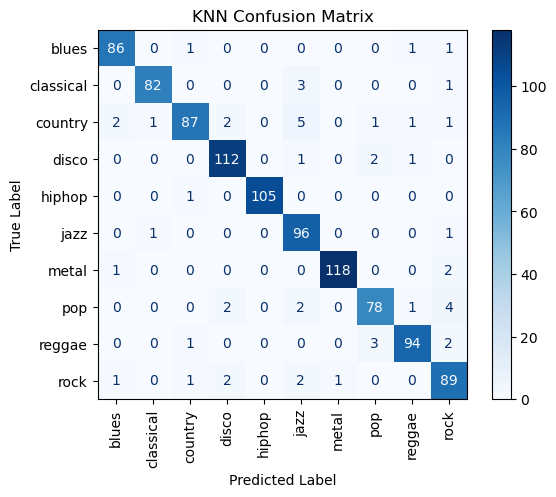

In [45]:
knn_classifier.fit(X_3sec_norm_fulltrain, y_3sec_fulltrain)
y_pred = knn_classifier.predict(X_3sec_norm_test)
knn_confusion = confusion_matrix(y_3sec_test, y_pred)
FP = knn_confusion.sum(axis=0) - np.diag(knn_confusion)
FN = knn_confusion.sum(axis=1) - np.diag(knn_confusion)
TP = np.diag(knn_confusion)
knn_precision = np.mean(TP/(TP+FP))
knn_recall = np.mean(TP/(TP+FN))
knn_f1 = (2*knn_precision*knn_recall)/(knn_precision+knn_recall)
knn_acc = np.mean(y_3sec_test == y_pred)
print('KNN F1 Score - ' + str(knn_f1))
print('KNN Precision Score - ' + str(knn_precision))
print('KNN Recall Score - ' + str(knn_recall))
print('KNN Accuracy - ' + str(knn_acc))
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion, display_labels=genres)
disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if desired
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation='vertical')
plt.show()

SVM F1 Score - 0.8381405438860013
SVM Precision Score - 0.8374755727244734
SVM Recall Score - 0.8388065718855875
SVM Accuracy - 0.8368368368368369


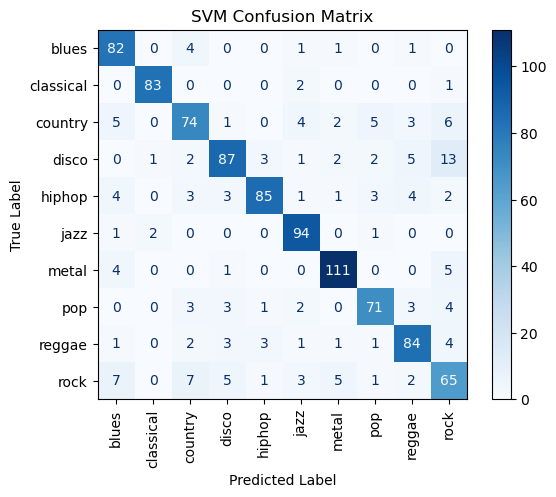

In [46]:
svm_classifier.fit(X_3sec_std_fulltrain, y_3sec_fulltrain)
y_pred = svm_classifier.predict(X_3sec_std_test)
svm_confusion = confusion_matrix(y_3sec_test, y_pred)
FP = svm_confusion.sum(axis=0) - np.diag(svm_confusion)
FN = svm_confusion.sum(axis=1) - np.diag(svm_confusion)
TP = np.diag(svm_confusion)
svm_precision = np.mean(TP/(TP+FP))
svm_recall = np.mean(TP/(TP+FN))
svm_f1 = (2*svm_precision*svm_recall)/(svm_precision+svm_recall)
svm_acc = np.mean(y_3sec_test == y_pred)
print('SVM F1 Score - ' + str(svm_f1))
print('SVM Precision Score - ' + str(svm_precision))
print('SVM Recall Score - ' + str(svm_recall))
print('SVM Accuracy - ' + str(svm_acc))
disp = ConfusionMatrixDisplay(confusion_matrix=svm_confusion, display_labels=genres)
disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if desired
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation='vertical')
plt.show()

Random Forest F1 Score - 0.9111701730463418
Random Forest Precision Score - 0.9105282718348893
Random Forest Recall Score - 0.9118129799470729
Random Forest Accuracy - 0.9099099099099099


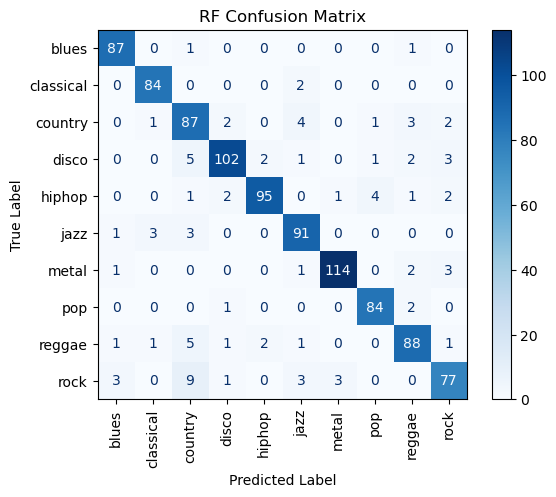

In [47]:
rf_classifier.fit(X_3sec_std_fulltrain, y_3sec_fulltrain)
y_pred = rf_classifier.predict(X_3sec_std_test)
rf_confusion = confusion_matrix(y_3sec_test, y_pred)
FP = rf_confusion.sum(axis=0) - np.diag(rf_confusion)
FN = rf_confusion.sum(axis=1) - np.diag(rf_confusion)
TP = np.diag(rf_confusion)
rf_precision = np.mean(TP/(TP+FP))
rf_recall = np.mean(TP/(TP+FN))
rf_f1 = (2*rf_precision*rf_recall)/(rf_precision+rf_recall)
rf_acc = np.mean(y_3sec_test == y_pred)
print('Random Forest F1 Score - ' + str(rf_f1))
print('Random Forest Precision Score - ' + str(rf_precision))
print('Random Forest Recall Score - ' + str(rf_recall))
print('Random Forest Accuracy - ' + str(rf_acc))
disp = ConfusionMatrixDisplay(confusion_matrix=rf_confusion, display_labels=genres)
disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if desired
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation='vertical')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
Convolutional Neural Network F1 Score - 0.5
Convolutional Neural Network Precision Score - 0.5
Convolutional Neural Network Recall Score - 0.5
Convolutional Neural Network Accuracy - 0.5


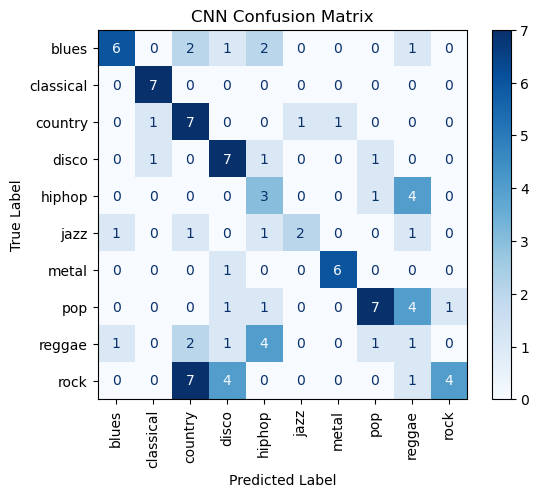

In [48]:
y_pred = cnn_classifier.predict(X_images_test)
y_pred_classes = np.array([])
for i in range(len(y_pred)):
    y_pred_classes = np.append(y_pred_classes, np.argmax(y_pred[i]))
cnn_confusion = tf.math.confusion_matrix(y_images_test.astype(int), y_pred_classes.astype(int)).numpy()
FP = np.sum(cnn_confusion.sum(axis=0) - np.diag(cnn_confusion))
FN = np.sum(cnn_confusion.sum(axis=1) - np.diag(cnn_confusion))
TP = np.sum(np.diag(cnn_confusion))
cnn_precision = np.mean(TP/(TP+FP))
cnn_recall = np.mean(TP/(TP+FN))
cnn_f1 = (2*cnn_precision*cnn_recall)/(cnn_precision+cnn_recall)
cnn_acc = np.mean(y_images_test.astype(int) == y_pred_classes.astype(int))
print('Convolutional Neural Network F1 Score - ' + str(cnn_f1))
print('Convolutional Neural Network Precision Score - ' + str(cnn_precision))
print('Convolutional Neural Network Recall Score - ' + str(cnn_recall))
print('Convolutional Neural Network Accuracy - ' + str(cnn_acc))
disp = ConfusionMatrixDisplay(confusion_matrix=cnn_confusion, display_labels=genres)
disp.plot(cmap=plt.cm.Blues)  # You can choose a different colormap if desired
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation='vertical')
plt.show()

In [49]:
# Plot results
bar1 = np.arange(len(knn_traintimes))
bar2 = [x + 0.2 for x in bar1]
bar3 = [x + 0.2 for x in bar2]
bar4 = [x + 0.2 for x in bar3]

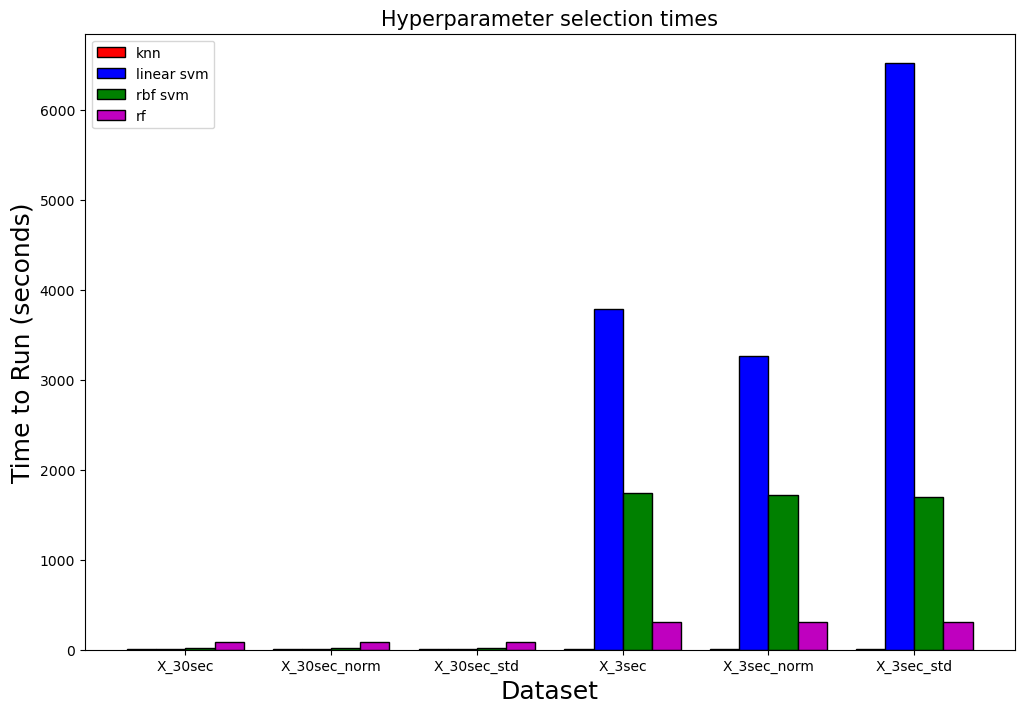

In [50]:
fig = plt.subplots(figsize = (12, 8))
plt.bar(bar1, knn_hypertimes, color = 'r', width = 0.2, edgecolor = 'black', label = 'knn')
plt.bar(bar2, svm_hypertimes, color = 'b', width = 0.2, edgecolor = 'black', label = 'linear svm')
plt.bar(bar3, rbf_hypertimes, color = 'g', width = 0.2, edgecolor = 'black', label = 'rbf svm')
plt.bar(bar4, rf_hypertimes, color = 'm', width = 0.2, edgecolor = 'black', label = 'rf')
plt.title('Hyperparameter selection times', fontsize = 15)
plt.ylabel('Time to Run (seconds)', fontsize = 18)
plt.xlabel('Dataset', fontsize = 18)
plt.xticks([x + 0.3 for x in range(len(bar1))], ['X_30sec', 'X_30sec_norm', 'X_30sec_std', 'X_3sec', 'X_3sec_norm', 'X_3sec_std'])
plt.legend()
plt.show()

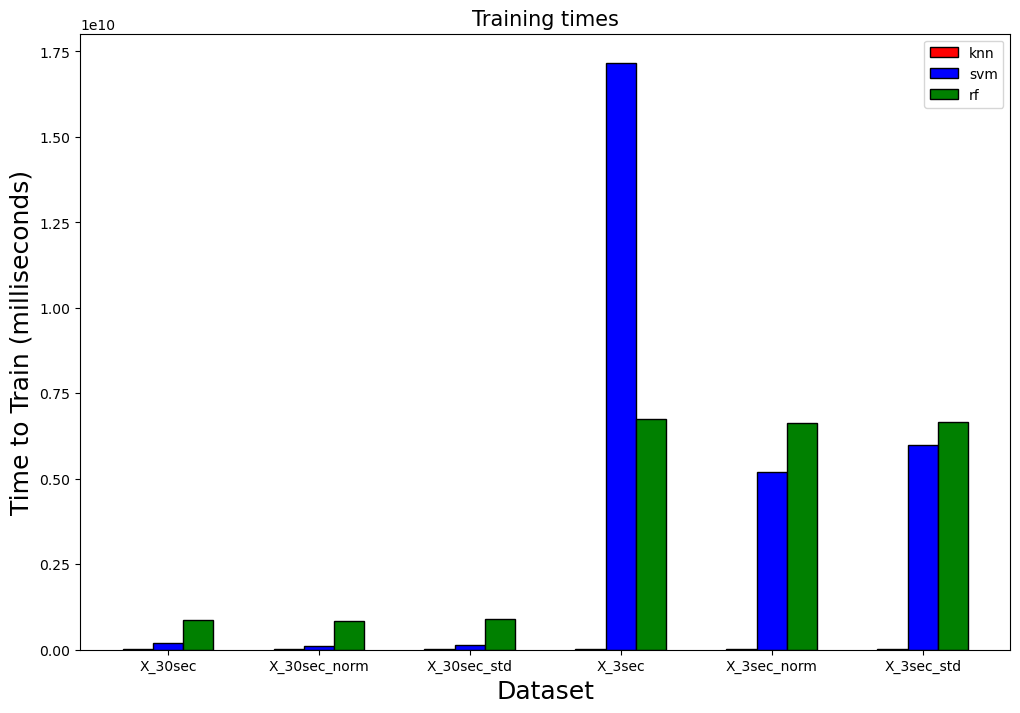

Convolutional Neural Network Train Time: 251 (seconds)


In [51]:
fig1 = plt.subplots(figsize = (12, 8))
plt.bar(bar1, knn_traintimes, color = 'r', width = 0.2, edgecolor = 'black', label = 'knn')
plt.bar(bar2, svm_traintimes, color = 'b', width = 0.2, edgecolor = 'black', label = 'svm')
plt.bar(bar3, rf_traintimes, color = 'g', width = 0.2, edgecolor = 'black', label = 'rf')
plt.title('Training times', fontsize = 15)
plt.ylabel('Time to Train (milliseconds)', fontsize = 18)
plt.xlabel('Dataset', fontsize = 18)
plt.xticks(bar2, ['X_30sec', 'X_30sec_norm', 'X_30sec_std', 'X_3sec', 'X_3sec_norm', 'X_3sec_std'])
plt.legend()
plt.show()

print('Convolutional Neural Network Train Time: ' + str(cnn_traintimes[0]) + ' (seconds)')

In [52]:
knn_precision
knn_recall
knn_f1
knn_acc

testdf = pd.DataFrame({
    "Classifier": ["Knn", "svm", "rf", "cnn"],
    "Precision": [
        knn_precision,
        svm_precision,
        rf_precision,
        cnn_precision
    ],
    "recall": [
        knn_recall,
        svm_recall,
        rf_recall,
        cnn_recall
    ],
    "f1": [
        knn_f1,
        svm_f1,
        rf_f1,
        cnn_f1
    ],
    "Accuracy": [
        knn_acc,
        svm_acc,
        rf_acc,
        cnn_acc
    ],

})
testdf

,Classifier,Precision,recall,f1,Accuracy
0,Knn,0.947822,0.946430,0.947125,0.947948
1,svm,0.837476,0.838807,0.838141,0.836837
2,rf,0.910528,0.911813,0.911170,0.909910
3,cnn,0.500000,0.500000,0.500000,0.500000


The KNN classifier demonstrated the strongest overall performance, with the highest F1 score of 0.947125, indicating excellent balance between precision and recall. Its accuracy of 0.947948 further supports its robust performance. In contrast, the SVM showed moderate performance across all metrics, with an average F1 score of 0.838141. The RF classifier performed well, with an F1 score of 0.915872, slightly below KNN but still impressive. The CNN, however, underperformed significantly, with all metrics at 0.5.

From analysing the confusion matrixes we were able to see that the KNN classifier showed relatively low misclassification rates spread evenly across all classes, which shows relativly good perfomance across all generes. In contrast, the SVM classifier exhibited higher misclassification rates for Disco, Hip-Hop, Country, and Rock genres. This indicates potential challenges in distinguishing between these specific music styles. The RF classifier showed moderate misclassification, particularly affecting the Rock genre. Interestingly, the CNN classifier had its misclassifications spread throughout all classes, suggesting inconsistent performance across different genres. These patterns highlight the strengths and weaknesses of each model in handling various music genres.

#### Testing additonal train and test splits 
Below are tests on addational train and test splits for classisifer compairsion. The goal of further analysis is to see how much the dataset, normalization, standardization, and the classifier affect the over all results. 

In [53]:
features_results = []
for X, y, data_set in features_datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    for classifier in features_classifiers:
        fit_start_time = time.time()
        classifier.fit(X_train, y_train)
        fit_stop_time = time.time()
        y_pred=classifier.predict(X_test)
        predict_stop_time = time.time()
        classifier_accuracy = np.mean(y_pred == y_test)
        fit_time = fit_stop_time - fit_start_time
        predict_time = predict_stop_time - fit_stop_time
        features_results.append([data_set, classifier.__class__.__name__, fit_time, predict_time, classifier_accuracy])


In [54]:
name_mapping = {
    "RandomForestClassifier": "RF",
    "SupportVectorClassifier": "SVM",
    "KNeighborsClassifier": "KNN",
    "DummyClassifier": "Random",
    "ConvolutionalNeuralNetwork": "CNN",	
}
columns = ["Dataset", "Classifier", "Fit Time (s)", "Predict Time (s)", "Accuracy"]
results_df = pd.DataFrame(features_results, columns=columns)
results_df["Classifier"] = results_df["Classifier"].replace(name_mapping)
columns = ["Dataset", "Classifier", "Fit Time (s)", "Predict Time (s)", "Accuracy"]


results_df

,Dataset,Classifier,Fit Time (s),Predict Time (s),Accuracy
0,Features 30 sec,KNN,0.007569,0.065686,0.253333
1,Features 30 sec,SVC,0.132484,0.063871,0.376667
2,Features 30 sec,RF,0.925357,0.105866,0.680000
3,Features 30 sec norm,KNN,0.003000,0.039639,0.653333
4,Features 30 sec norm,SVC,0.075650,0.050619,0.726667
5,Features 30 sec norm,RF,0.801904,0.116549,0.680000
6,Features 30 sec std,KNN,0.002545,0.030264,0.663333
7,Features 30 sec std,SVC,0.101651,0.056132,0.716667
8,Features 30 sec std,RF,0.831998,0.128924,0.683333
9,Features 3 sec,KNN,0.016881,0.103988,0.255255


The performance improvement observed when transitioning from 30-second features to 3-second features is likely due to the increased number of training examples available with shorter segments. This increase in data can enhance the model's ability to learn patterns more effectively. Additionally, the use of normalized and standardized data further improved performance. These preprocessing techniques ensure that all features contribute equally to the model by bringing them to a common scale. The below dataframe shows accuracy and times averaged across all classifiers. 

In [55]:
dataset_averages = {}
for dataset_name in results_df["Dataset"].unique():
    filtered_df = results_df[results_df["Dataset"] == dataset_name]
    averages = filtered_df[["Fit Time (s)", "Predict Time (s)", "Accuracy"]].mean()
    dataset_averages[dataset_name] = averages
dataset_averages_df = pd.DataFrame.from_dict(dataset_averages, orient="index")
dataset_averages_df

,Fit Time (s),Predict Time (s),Accuracy
Features 30 sec,0.355136,0.078474,0.436667
Features 30 sec norm,0.293518,0.068936,0.686667
Features 30 sec std,0.312065,0.071773,0.687778
Features 3 sec,5.057149,2.194382,0.488266
Features 3 sec norm,4.854967,1.315750,0.905350
Features 3 sec std,3.025311,1.534680,0.903793


The Random Forest (RF) classifier demonstrated superior performance when averaged across all datasets, including the normalized, and standardized data.This suggests that RF is particularly effective in handling the variability and complexity of these datasets. In contrast, the Support Vector Machine (SVM) and k-Nearest Neighbors (KNN) classifiers showed relatively similar performance levels, indicating that they might be equally suited for this task but not as robust as RF in this context. Regarding prediction times, both KNN and RF exhibited similar speeds, which is advantageous for applications requiring quick predictions. However, SVM had the highest prediction time, which could be a drawback in time-sensitive scenarios. On the other hand, KNN had a significantly lower training time compared to SVM and RF, making it a more efficient choice when computational resources or time are limited during the training phase. This analysis highlights the trade-offs between accuracy, prediction speed, and training time when choosing a classifier for specific applications. 

In [56]:
classifier_averages = {}
for classifier_name in results_df["Classifier"].unique():
    filtered_df = results_df[results_df["Classifier"] == classifier_name]
    averages = filtered_df[["Fit Time (s)", "Predict Time (s)", "Accuracy"]].mean()
    classifier_averages[classifier_name] = averages.to_dict()  # Convert Series to dict
classifier_averages_df = pd.DataFrame.from_dict(classifier_averages, orient="index")
classifier_averages_df 

,Fit Time (s),Predict Time (s),Accuracy
KNN,0.009598,0.067671,0.608958
SVC,2.983505,2.402183,0.657743
RF,3.955970,0.162144,0.787558


The KNN classifier showed worse performance when data was not normalized or standardized. This is likely because without normalization, features with larger ranges can disproportionately influence the model's decisions, leading to suboptimal classifications./ The accuracy improved with the 3 second dataset which shows that a larger training set may have a large impact in accuracy. 


In [57]:
# Filter the DataFrame for KNN results
knn_results_df = results_df[results_df['Classifier'] == 'KNN']

# Display the filtered DataFrame
knn_results_df[["Dataset", "Classifier", "Fit Time (s)", "Predict Time (s)", "Accuracy"]]

,Dataset,Classifier,Fit Time (s),Predict Time (s),Accuracy
0,Features 30 sec,KNN,0.007569,0.065686,0.253333
3,Features 30 sec norm,KNN,0.003000,0.039639,0.653333
6,Features 30 sec std,KNN,0.002545,0.030264,0.663333
9,Features 3 sec,KNN,0.016881,0.103988,0.255255
12,Features 3 sec norm,KNN,0.009997,0.088477,0.925926
15,Features 3 sec std,KNN,0.017594,0.077973,0.902569


The SVM classifier outperformed the KNN classifier in terms of accuracy on non-normalized data and for the smaller feature dataset. However, SVM had significantly longer training times compared to KNN. Interestingly, the improvement from 30-second data to 3-second data was less pronounced for SVM compared to other classifiers. This suggests that SVM might be more robust to changes in data window size but at the cost of increased computational complexity during training. The larger training times for SVM could make it less suitable for scenarios requiring rapid model updates or when dealing with large datasets where computational resources are limited.

In [58]:
# Filter the DataFrame for KNN results
svm_results_df = results_df[results_df['Classifier'] == 'SVC']

# Display the filtered DataFrame
svm_results_df[["Dataset", "Classifier", "Fit Time (s)", "Predict Time (s)", "Accuracy"]]

,Dataset,Classifier,Fit Time (s),Predict Time (s),Accuracy
1,Features 30 sec,SVC,0.132484,0.063871,0.376667
4,Features 30 sec norm,SVC,0.075650,0.050619,0.726667
7,Features 30 sec std,SVC,0.101651,0.056132,0.716667
10,Features 3 sec,SVC,10.196832,6.272203,0.315649
13,Features 3 sec norm,SVC,3.434992,3.649940,0.895229
16,Features 3 sec std,SVC,3.959421,4.320333,0.915582


The RF classifier performed similarly to SVM for normalized and standardized data, showcasing their robustness to data preprocessing techniques. Both models benefited from the transition to 3-second features, likely due to the increased detail and removal of biases. Notably, RF excelled in non-standardized and non-normalized data, outperforming both SVM and KNN in this scenario. This suggests RF's adaptability to various data conditions. The predict time was significantly shorter than the fit time for RF, indicating faster inference but longer training periods. This trade-off may be acceptable given RF's superior performance across different data types and preprocessing methods.

In [59]:
# Filter the DataFrame for KNN results
rf_results_df = results_df[results_df['Classifier'] == 'RF']

# Display the filtered DataFrame
rf_results_df[["Dataset", "Classifier", "Fit Time (s)", "Predict Time (s)", "Accuracy"]]

,Dataset,Classifier,Fit Time (s),Predict Time (s),Accuracy
2,Features 30 sec,RF,0.925357,0.105866,0.680000
5,Features 30 sec norm,RF,0.801904,0.116549,0.680000
8,Features 30 sec std,RF,0.831998,0.128924,0.683333
11,Features 3 sec,RF,4.957733,0.206956,0.893894
14,Features 3 sec norm,RF,11.119913,0.208833,0.894895
17,Features 3 sec std,RF,5.098917,0.205736,0.893227


### Conclusions 
The CNN performed worse than expected, potentially due to suboptimal hyperparameters. Due to some time constraints with being students, we were unable to thoroughly optimize hyperparameters for all models. We couldn't allow models to run for extended periods, limiting our exploration of optimal configurations. The absence of hardware acceleration for the CNN significantly slowed down our analysis. It was interesting to see results with the CNN time paramters when run on different computers. This limitation prevented us from conducting comprehensive experiments. We had to monitor and interrupt computations frequently, preventing truly unattended runs. These limitations forced us to make compromises in model training and evaluation, potentially impacting the final performance of our classifiers. Despite these challenges, we aimed to extract meaningful insights from our constrained experiments, keeping in mind that further optimizations could yield improved results with more computational resources and time for thorough hyperparameter tuning.

All the implemented classifiers (KNN, SVM, RF, and CNN) outperformed the dummy classifier, which had an accuracy of only 10% indicating that even simple machine learning approaches can significantly improve classification accuracy beyond random guessing.  

Surprisingly, KNN achieved the best accuracy, precision, and recall on 3-second standardized data, though its overall performance wasn't outstanding across all datasets. RF emerged as the most robust performer across normalized, standardized, and raw data, boasting the highest accuracy across all datasets. SVM fell in the middle for accuracy but suffered from lengthy training and testing times. This analysis underscores the critical importance of hyperparameter selection, thorough data understanding, and proper data preprocessing. Larger datasets generally yielded better results, highlighting the value of increased sample sizes. Further investigation into PCA could be beneficial, as the current feature set may contain redundant information. Additionally, optimizing hyperparameters or increasing training epochs might lead to improved performance across all models. This study demonstrates that careful consideration of data preprocessing, model selection, and hyperparameter tuning is crucial for achieving optimal classification performance in machine learning tasks.
